> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
 which enables dynamical simulations of ordered and thermally disordered spins with dipole
 and higher order moments._

## Welcome to a Sunny Tutorial on the Chiral Triangular Lattice System Ba<sub>3</sub>NbFe<sub>3</sub>Si<sub>2</sub>O<sub>14</sub>
**Script**: Chiral Triangular Lattice Calculation <br>
**Inspired by**:Ba<sub>3</sub>NbFe<sub>3</sub>Si<sub>2</sub>O<sub>14</sub> SpinW tutorial
  (Toth et al. https://spinw.org/tutorials/15tutorial). Crystal structure from Marty et al.
   http://dx.doi.org/10.1103/PhysRevLett.101.247201 and inelastic data from Loire et al.
   http://dx.doi.org/10.1103/PhysRevLett.106.207201 <br>
**Authors**: Harry Lane <br>
**Date**: September 11, 2023  (Sunny 0.5.4) <br>
**Goal**: This script is to calculate the linear spin wave theory spectrum for
   Ba<sub>3</sub>NbFe<sub>3</sub>Si<sub>2</sub>O<sub>14</sub> and compare with the results from SpinW.

---
#### Loading Packages

In [1]:
using Sunny, GLMakie, LinearAlgebra, ColorTypes

---
### System Definition for Ba<sub>3</sub>NbFe<sub>3</sub>Si<sub>2</sub>O<sub>14</sub>
Set up a `Crystal` using the parameters from
    <a href="http://dx.doi.org/10.1103/PhysRevLett.101.247201 ">Marty et al., Phys. Rev. Lett. **101**, 247201</a>

In [2]:
a = b = 8.539 # (Å)
c = 5.2414
latvecs = lattice_vectors(a, b, c, 90, 90, 120)
types = ["Fe","Nb","Ba","Si","O","O","O"]
langasite = Crystal(latvecs, [[0.24964,0,0.5],[0,0,0],[0.56598,0,0],[2/3,1/3,0.5220],[2/3,1/3,0.2162],[0.5259,0.7024,0.3536],[0.7840,0.9002,0.7760]], 150;types)
crystal = subcrystal(langasite, "Fe")
view_crystal(crystal, 2.6,rescale=1.5)

print_symmetry_table(crystal,7.0)

Atom 1
Type 'Fe', position [0.2496, 0, 0.5], multiplicity 3
Allowed g-tensor: |   A    0    0 |
                  |   0    B  D+E |
                  |   0  D-E    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-1] + c₂*𝒪[2,0] + c₃*𝒪[2,2] +
    c₄*𝒪[4,-3] + c₅*𝒪[4,-1] + c₆*𝒪[4,0] + c₇*𝒪[4,2] + c₈*𝒪[4,4] +
    c₉*𝒪[6,-5] + c₁₀*𝒪[6,-3] + c₁₁*𝒪[6,-1] + c₁₂*𝒪[6,0] + c₁₃*𝒪[6,2] + c₁₄*𝒪[6,4] + c₁₅*𝒪[6,6]
Allowed exchange matrix: |   A    0    0 |
                         |   0    B  D+E |
                         |   0  D-E    C |
Allowed DM vector: [E 0 0]

Bond(3, 2, [1, 1, 0])
Distance 3.69217106799316, coordination 2
Connects 'Fe' at [0.7504, 0.7504, 0.5] to 'Fe' at [1, 1.2496, 0.5]
Allowed exchange matrix: | A  F -E |
                         |-F  B  D |
                         | E  D  C |
Allowed DM vector: [0 E F]

Bond(1, 1, [0, 0, 1])
Distance 5.2414, coordination 2
Connects 'Fe' at [0.2496, 0, 0.5] to 'Fe' at [0.2496, 0, 1.5]
Allowed exchange matrix: | A  F -E |
         

Create a `System` with a lattice size of $(1,1,7)$. The magnetic structure of
Ba<sub>3</sub>NbFe<sub>3</sub>Si<sub>2</sub>O<sub>14</sub> was determine to have the ordering
wavevector $\mathbf{Q}=(0,0,1/7)$ and hence the magnetic unit cell has 7 sites.
By passing an explicit seed, the system's random number generator will give repeatable results.

In [3]:
latsize = (1,1,7)
rn_seed = 5
S = 5/2
J₁ = 0.85
J₂ = 0.24
J₃ = 0.053
J₄ = 0.017
J₅ = 0.24
sys = System(crystal, latsize, [SpinInfo(1; S, g=2)], :dipole; seed=rn_seed)
set_exchange!(sys, J₁, Bond(3, 2, [1,1,0]))
set_exchange!(sys, J₄, Bond(1, 1, [0,0,1]))
set_exchange!(sys, J₂, Bond(1, 3, [0,0,0]))

The final two exchanges can be define the chirality of the magnetic structure.
The crystal chirality, $\epsilon_{T}$, the chirality of each triangle, $\epsilon_{D}$ and the
sense of rotation of the spin helices along $c$, $\epsilon_{H}$. The three chiralities are
related by $\epsilon_{T}=\epsilon_{D}\epsilon_{H}$. We now assign $J_{3}$ and $J_{5}$ according
to the crystal chirality.

In [4]:
ϵD = -1
ϵH = +1
ϵT = ϵD * ϵH

if ϵT == -1
    set_exchange!(sys,J₃,Bond(2, 3, [-1,-1,1]))
    set_exchange!(sys,J₅, Bond(3, 2, [1,1,1]))
elseif ϵT == 1
    set_exchange!(sys,J₅,Bond(2, 3, [-1,-1,1]))
    set_exchange!(sys,J₃, Bond(3, 2, [1,1,1]))
else
    throw("Provide a valid chirality")
end

---
### Find ground-state of the system

We can now find the classical ground state, first with langevin sampling,
then using gradient descent.

In [5]:
randomize_spins!(sys)
Δt = 0.01/J₁
λ = 0.1
langevin = Langevin(Δt; kT=0, λ)
langevin.kT = 0.0
for _ ∈ 1:2_000
    step!(sys, langevin)
end
minimize_energy!(sys;maxiters=1000);

The expected ground state is a helical structure with a chirality determined by
sign of the crystal chirality defined above. The ordering wavevector is $\mathbf{Q}=(0,0,1/7)$.
Let's print the predominant wavevectors using `print_wrapped_intensities`.

In [6]:
print_wrapped_intensities(sys)

Dominant wavevectors for spin sublattices:

    [0, 0, 1/7]            50.00% weight
    [0, 0, -1/7]           50.00%


We find that the the wavevectors $[0,0,\pm 1/7]$ are the only vectors with finite weight.
Let's plot the ground state we found.

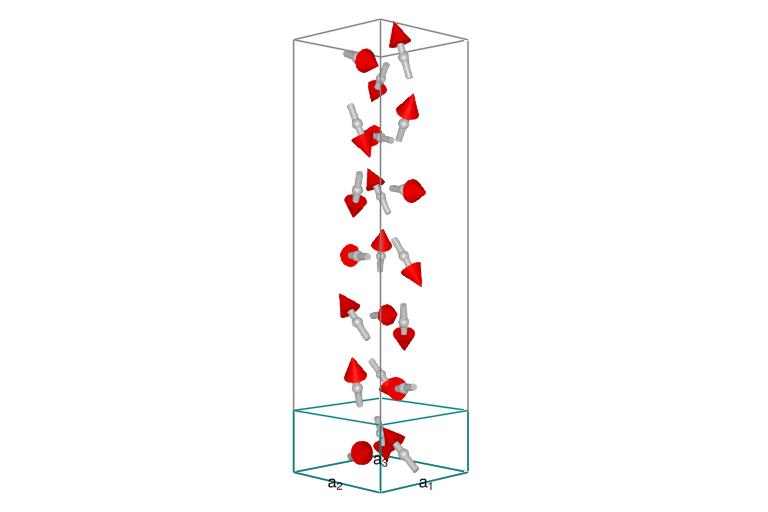

In [7]:
plot_spins(sys)

Whilst we found the correct magnetic structure, in many cases the structure is known experimentally.
For large unit cell sizes and frustrated systems, finding the ground state by numerical optimization
may be prohibitively expensive. In these cases, it may be preferable to directly define
the magnetic structure using the experimentally determined parameters. To do this we use the
`define_magnetic_structure`function that takes a normal vector to the rotation plane
of the spins, $\mathbf{n}$, and the ordering wavevector $\mathbf{Q}$.

In [8]:
kvec=[0,0,0.142857] # provide a decimal to show off the rationalization of an incommensurate wavevector
S1=[1.0, 0, 0]*(5/2)
S2=[-0.5, -sqrt(3)/2, 0]*(5/2)
S3=[-0.5, sqrt(3)/2, 0]*(5/2)
Slist=[S1,S2,S3]
n=[0,0,1]
for nsub in 1:3
    set_spiral_order_on_sublattice!(sys, nsub ;q=kvec,axis=n,S0=Slist[nsub])
end

┌ Warning: Wavevector [0, 0, 0.1429] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254
┌ Warning: Wavevector [0, 0, 0.1429] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254
┌ Warning: Wavevector [0, 0, 0.1429] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254


The structure is the same as that which we found in our minimization, up to a global rotation
factor owing to the U(1) symmetry of the model.

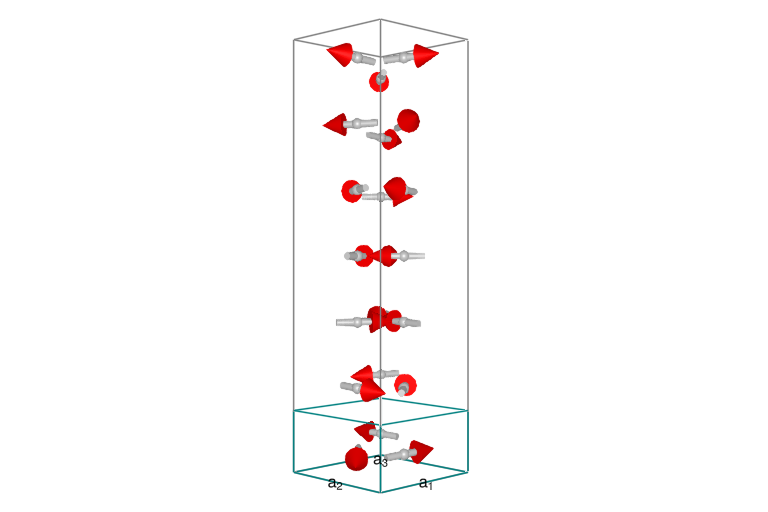

In [9]:
plot_spins(sys)

---
### Calculating Spin Wave Theory

The next step is to build a `SpinWaveTheory` object.

In [10]:
swt = SpinWaveTheory(sys);

Before calculating the linear spin wave intensity, we must define a path in reciprocal space.
We plot along the direction $[0,1,-1+\xi]$.

In [11]:
points_rlu = [[0,1,-1],[0,1,-1+1],[0,1,-1+2],[0,1,-1+3]];
density = 100
path, xticks = reciprocal_space_path(crystal,points_rlu, density);

We now create an intensity formula, specifying a Lorentzian linewidth, with a width of $0.15$ meV.

In [12]:
γ = 0.15 # width in meV
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))

Quantum Scattering Intensity Formula
At any (Q,ω), with S = S(Q,ωᵢ):

  Intensity(Q,ω) = ∑ᵢ Kernel(ω-ωᵢ) ∑_ij (I - Q⊗Q){i,j} S{i,j}
                                   
                                   (i,j = Sx,Sy,Sz)

Intensity(ω) reported


Finally we plot the broadened neutron scattering intensity along the path we defined above.

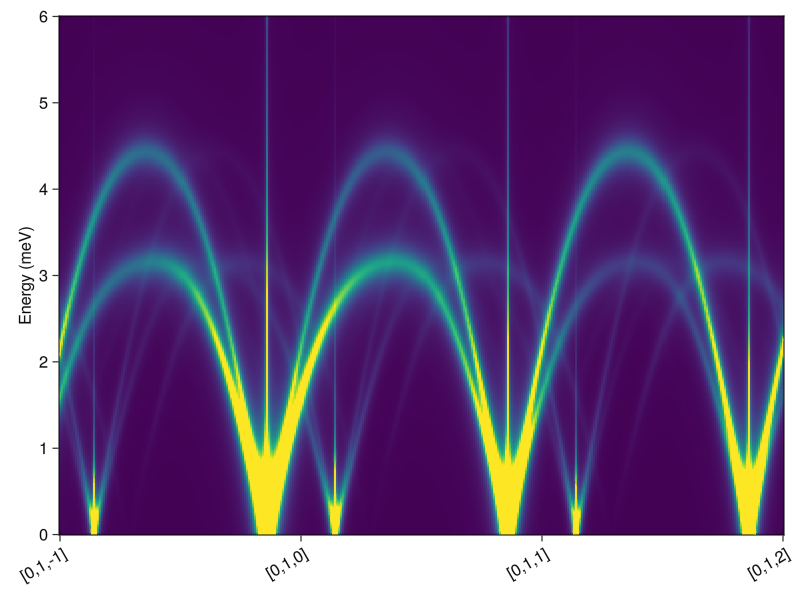

In [13]:
energies = collect(0:0.01:6)  # 0 < ω < 6 (meV).
is = intensities_broadened(swt, [q for q in path], energies, broadened_formula)
fig = Figure()
ax = Axis(fig[1,1]; ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
heatmap!(ax, 1:size(is, 1), energies, is,colorrange = (0,5.0))
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*